<a href="https://colab.research.google.com/github/MariusMC8/Thesis-coding/blob/main/Risk_ranking_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas matplotlib

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [3]:
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_ESP_1.json"
regions = gpd.read_file(url)

# Climate indicator: Hot Days above 35C (Climate-ADAPT)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Template storage data to analyse.csv to Template storage data to analyse.csv


In [5]:
import os

old_name = "Template storage data to analyse.csv"
new_name = "Hot_days_35C.csv"

os.rename(old_name, new_name)

In [6]:
data = pd.read_csv("Hot_days_35C.csv", sep=';', decimal=",", encoding='latin1')
data.head()

,ï»¿ID,Coordinates,Storage type,Region,Status,Power (MW),Capacity (MWh),Duration (hours),Importance score
0,Malpica Wind plus hybrid storage,"43.320000 , -8.810000",Battery,Galicia,Announced,7.75,15.5,2.00,2
1,BESS Sanxenxo,"42.400000 , -8.810000",Battery,Galicia,Announced,5.00,20.0,4.00,2
2,Santiago-Jares,"42.390000 , -7.090000",Battery,Galicia,Operational,5.00,5.0,1.00,2
3,Conso,"42.250000 , -7.160000",PHS,Galicia,Operational,270.00,2280.0,8.44,3
4,Soutelo PSP,"42.150000 , -7.190000",PHS,Galicia,Operational,215.00,NaN,NaN,3


In [7]:
#Fix Storage ID name
data.columns = data.columns.str.replace('ï»¿', 'Storage')

#Identify region names
data.columns = data.columns.str.strip()
data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaÃ\xadsVasco',
       'ComunidadForaldeNavarra', 'AragÃ³n', 'CataluÃ±a', 'IslasBaleares',
       'ComunidadValenciana', 'RegiÃ³ndeMurcia', 'AndalucÃ\xada',
       'CastillayLeÃ³n', 'CeutayMelilla', 'IslasCanarias', 'Extremadura',
       'Castilla-LaMancha'], dtype=object)

In [8]:
#Fix region names
region_fix = {
    "PaÃ\xadsVasco": "PaísVasco",
    "AragÃ³n": "Aragón",
    "CataluÃ±a": "Cataluña",
    "RegiÃ³ndeMurcia": "RegióndeMurcia",
    "AndalucÃ\xada": "Andalucía",
    "CastillayLeÃ³n": "CastillayLeón"}

data["Region"] = data["Region"].replace(region_fix)

data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaísVasco',
       'ComunidadForaldeNavarra', 'Aragón', 'Cataluña', 'IslasBaleares',
       'ComunidadValenciana', 'RegióndeMurcia', 'Andalucía',
       'CastillayLeón', 'CeutayMelilla', 'IslasCanarias', 'Extremadura',
       'Castilla-LaMancha'], dtype=object)

In [9]:
# Remove BOM, whitespace, invisible characters
data['Storage type'] = (
    data['Storage type']
    .astype(str)
    .str.encode('utf-8', 'ignore')
    .str.decode('utf-8')
    .str.replace('\u200b', '', regex=False)  # zero-width space
    .str.replace('\xa0', ' ', regex=False)   # non-breaking space
    .str.strip()
)

In [10]:
# Split coordinates into latitude and longitude
data[['lat','lon']] = data['Coordinates'].str.split(',', expand=True).astype(float)

In [11]:
# Convert coordinates to geodataframe
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

In [12]:
#Hot days above 35°C 1991-2020 for each region
hot_days_35_present_dict = {
    "Galicia": 0.4,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.02,
    "PaísVasco": 0.16,
    "ComunidadForaldeNavarra": 3.59,
    "Aragón": 6.82,
    "Cataluña": 2.14,
    "ComunidadValenciana": 3.04,
    "RegióndeMurcia": 5.8,
    "Andalucía": 17.13,
    "Castilla-LaMancha": 14.12,
    "CastillayLeón": 1.94,
    "Extremadura": 21.32,
    "IslasCanarias": 0.02,
    "IslasBaleares": 0.11,
    "CeutayMelilla": 2.47,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 1991-2020"] = data["Region"].map(hot_days_35_present_dict)

In [13]:
#Define bins for hazard strength
bins = [-float("inf"), 1, 5, 15, 25, float("inf")]
labels = [0, 1, 2, 3, 4]

data['Hot days >35C 1991-2020 strength'] = pd.cut(
    data['Hot days >35C 1991-2020'].astype(float),
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
).astype(int)

In [14]:
#Vulnerability score
vulnerability_hot_days_35 = {
    "Battery": 3,
    "PHS": 2,
    "Flywheel": 1
}

data["Vulnerability hot days >35C"] = data["Storage type"].map(vulnerability_hot_days_35)

In [15]:
#Increase in number of hot days above 35°C from 1991-2020 to 2011-2040 RCP4.5 for each region
hot_days_35_change45_dict = {
    "Galicia": 0.12,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.04,
    "PaísVasco": 0.23,
    "ComunidadForaldeNavarra": 1.55,
    "Aragón": 2.71,
    "Cataluña": 0.98,
    "ComunidadValenciana": 1.57,
    "RegióndeMurcia": 3.11,
    "Andalucía": 4.65,
    "Castilla-LaMancha": 5.65,
    "CastillayLeón": 1.61,
    "Extremadura": 5.95,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.13,
    "CeutayMelilla": 1.22,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C change RCP4.5"] = data["Region"].map(hot_days_35_change45_dict)

In [16]:
#Define bins for future exposure score RCP4.5
bins = [-float("inf"), 1, 5, 15, 25, float("inf")]
labels = [0, 1, 2, 3, 4]

data["Hot days >35C future exposure score RCP4.5"] = pd.cut(
    data["Hot days >35C change RCP4.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [17]:
#Increase in number of hot days above 35°C from 1991-2020 to 2011-2040 RCP8.5 for each region
hot_days_35_change85_dict = {
    "Galicia": 0.11,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.04,
    "PaísVasco": 0.25,
    "ComunidadForaldeNavarra": 1.79,
    "Aragón": 3.20,
    "Cataluña": 1.10,
    "ComunidadValenciana": 1.95,
    "RegióndeMurcia": 3.78,
    "Andalucía": 6.63,
    "Castilla-LaMancha": 7.42,
    "CastillayLeón": 2.09,
    "Extremadura": 8.94,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.15,
    "CeutayMelilla": 1.29,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C change RCP8.5"] = data["Region"].map(hot_days_35_change85_dict)

In [18]:
#Define bins for future exposure score RCP8.5
bins = [-float("inf"), 1, 5, 15, 25, float("inf")]
labels = [0, 1, 2, 3, 4]

data["Hot days >35C future exposure score RCP8.5"] = pd.cut(
    data["Hot days >35C change RCP8.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [20]:
#Future vulnerability score (vulnerability score x exposure score)
data['Future_vulnerability_score4.5'] = data["Vulnerability hot days >35C"] * data["Hot days >35C future exposure score RCP4.5"]
data['Future_vulnerability_score8.5'] = data["Vulnerability hot days >35C"] * data["Hot days >35C future exposure score RCP8.5"]

In [21]:
#Hot days above 35C 2011-2040 RCP4.5 for each region
hot_days_35_future45_dict = {
    "Galicia": 0.19,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.05,
    "PaísVasco": 0.38,
    "ComunidadForaldeNavarra": 4.83,
    "Aragón": 8.94,
    "Cataluña": 2.92,
    "ComunidadValenciana": 4.31,
    "RegióndeMurcia": 8.7,
    "Andalucía": 20.73,
    "Castilla-LaMancha": 18.91,
    "CastillayLeón": 3.58,
    "Extremadura": 26.69,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.26,
    "CeutayMelilla": 3.84,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 2011-2040 RCP4.5"] = data["Region"].map(hot_days_35_future45_dict)

In [22]:
#Define bins for future hazard strength RCP4.5
bins = [-float("inf"), 1, 5, 15, 25, float("inf")]
labels = [0, 1, 2, 3, 4]

data["Hot days >35C 2011-2040 hazard strength RCP4.5"] = pd.cut(
    data["Hot days >35C 2011-2040 RCP4.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [23]:
#Hot days above 35C 2011-2040 RCP8.5 for each region
hot_days_35_future85_dict = {
    "Galicia": 0.18,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.05,
    "PaísVasco": 0.43,
    "ComunidadForaldeNavarra": 5.15,
    "Aragón": 9.53,
    "Cataluña": 3.09,
    "ComunidadValenciana": 4.76,
    "RegióndeMurcia": 9.26,
    "Andalucía": 22.75,
    "Castilla-LaMancha": 20.78,
    "CastillayLeón": 4.13,
    "Extremadura": 29.83,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.29,
    "CeutayMelilla": 3.97,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 2011-2040 RCP8.5"] = data["Region"].map(hot_days_35_future85_dict)

In [24]:
#Define bins for future hazard strength RCP8.5
bins = [-float("inf"), 1, 5, 15, 25, float("inf")]
labels = [0, 1, 2, 3, 4]

data["Hot days >35C 2011-2040 hazard strength RCP8.5"] = pd.cut(
    data["Hot days >35C 2011-2040 RCP8.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [25]:
#Calculating present risk
data['risk_current'] = (
    data['Hot days >35C 1991-2020 strength'].astype(float) *
    data['Vulnerability hot days >35C'].astype(float) *
    data['Importance score'].astype(float) )
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Calculating future risk RCP4.5
data['risk_future_RCP4.5'] = (
    data['Hot days >35C 2011-2040 hazard strength RCP4.5'].astype(float) *
    data['Future_vulnerability_score4.5'].astype(float) *
    data['Importance score'].astype(float) )
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Calculating future risk RCP8.5
data['risk_future_RCP8.5'] = (
    data['Hot days >35C 2011-2040 hazard strength RCP8.5'].astype(float) *
    data['Future_vulnerability_score8.5'].astype(float) *
    data['Importance score'].astype(float) )
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Calculating change in risk
data['risk_change4.5'] = (
    data['risk_future_RCP4.5'] - data['risk_current'] )

data['risk_change8.5'] = (
    data['risk_future_RCP8.5'] - data['risk_current'] )

In [26]:
#Normalise and create colour map for risk values
norm = mcolors.Normalize(vmin=data['risk_current'].min(), vmax=data['risk_current'].max())
cmap = cm.ScalarMappable(norm=norm, cmap='Reds')

In [27]:
# Ensure numeric columns
cols_to_numeric = [
    'Hot days >35C 1991-2020 strength',
    'Hot days >35C 2011-2040 hazard strength RCP4.5',
    'Hot days >35C 2011-2040 hazard strength RCP8.5',
    'Vulnerability hot days >35C',
    'Importance score',
    'Hot days >35C future exposure score RCP4.5',
    'Hot days >35C future exposure score RCP8.5',
    'Future_vulnerability_score4.5',
    'Future_vulnerability_score8.5',
    'risk_current',
    'risk_future_RCP4.5',
    'risk_future_RCP8.5',
    'risk_change4.5',
    'risk_change8.5'
]
for col in cols_to_numeric:
    data[col] = pd.to_numeric(data[col], errors='coerce')

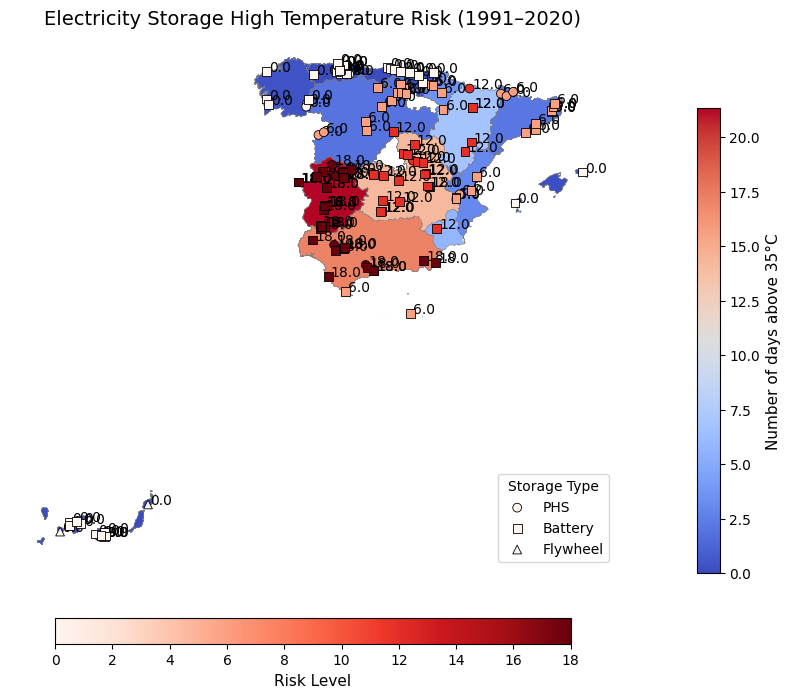

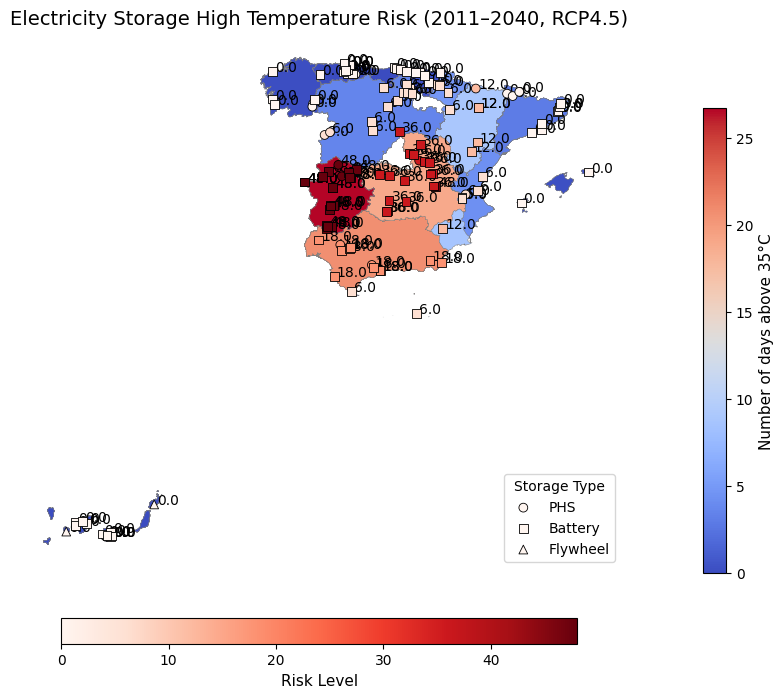

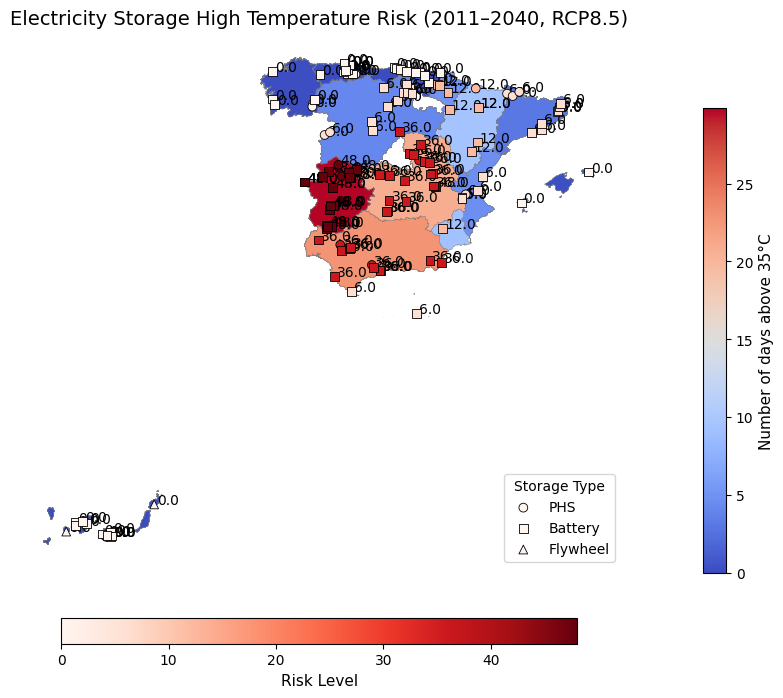

In [28]:
# Function for plotting 1
def plot_map(temp_col, risk_col, title, temp_change=False):
  fig, ax = plt.subplots(figsize=(10, 8))

  # Merge temperature data with regions for plotting background
  merged_regions_temp = regions.merge(data[['Region', temp_col]], left_on="NAME_1", right_on="Region", how="left")

  # Background = regional mean temperature
  merged_regions_temp.plot(column=temp_col, cmap="coolwarm", legend=False, ax=ax, edgecolor='grey', linewidth=0.3)

# --- BEFORE the overlay, compute shared norm for the risk_col ---
# use points[risk_col] (ensure it's numeric)
  vals = points[risk_col].to_numpy(dtype=float)
# decide vmin/vmax. For change maps we want symmetric range around 0:
  if temp_change:
    abs_max = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -abs_max, abs_max
    norm_risk = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap_risk = 'RdBu_r'
  else:
    vmin, vmax = vals.min(), vals.max()
    norm_risk = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_risk = 'Reds'


  #Overlay storage facilities
  markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}
  # plotting order: put larger markers first if you want them behind
  for t, marker in markers.items():
    subset = points[points['Storage type'] == t].copy()
    if subset.empty:
       continue
    xs = subset.geometry.x.values
    ys = subset.geometry.y.values
    cs = subset[risk_col].astype(float).values  # colour values

    sc = ax.scatter(
        xs, ys,
        c=cs,
        cmap=cmap_risk,
        norm=norm_risk,
        marker=marker,
        s=40,               # control marker size here
        edgecolor='black',
        linewidth=0.6,
        label=t,
        zorder=5
    )
# keep reference to the ScalarMappable for the colorbar
  sm_for_colorbar = sc

    # Add text labels to the points
  for i, row in points.iterrows():
      # Check if the risk value is not NaN before adding text
      if pd.notna(row[risk_col]):
          ax.text(row.geometry.x + 0.1, row.geometry.y, f"{row[risk_col]:.1f}", fontsize=10)

  #Add colour bar for temperature (right side)
  sm_temp = cm.ScalarMappable(
        norm=plt.Normalize(
            vmin=merged_regions_temp[temp_col].min(),
            vmax=merged_regions_temp[temp_col].max()
        ),
        cmap='coolwarm'
    )
  cbar_temp = fig.colorbar(sm_temp, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
  cbar_temp.set_label('Number of days above 35°C', fontsize=11)

  #Add colour bar for risk values (bottom)
  sm_risk = cm.ScalarMappable(norm=norm_risk, cmap=cmap_risk)
  sm_risk.set_array([])   # necessary in some Matplotlib versions
  cbar_risk = fig.colorbar(sm_risk, ax=ax, orientation='horizontal',
                         fraction=0.05, pad=0.08, shrink=0.7)
  cbar_risk.set_label('Change in Risk Level' if temp_change else 'Risk Level', fontsize=11)

  plt.legend(title="Storage Type", loc='lower right')
  plt.title(title, fontsize=14)
  plt.axis('off')
  plt.show()

# Update the points GeoDataFrame to include the calculated risk columns
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

#Map 1: Current risk
plot_map( temp_col='Hot days >35C 1991-2020',
         risk_col='risk_current',
          title='Electricity Storage High Temperature Risk (1991–2020)' )

#Map 2: Future risk RCP4.5
plot_map( temp_col='Hot days >35C 2011-2040 RCP4.5',
         risk_col='risk_future_RCP4.5',
          title='Electricity Storage High Temperature Risk (2011–2040, RCP4.5)')

#Map 3: Future risk RCP8.5
plot_map( temp_col='Hot days >35C 2011-2040 RCP8.5',
         risk_col='risk_future_RCP8.5',
          title='Electricity Storage High Temperature Risk (2011–2040, RCP8.5)')

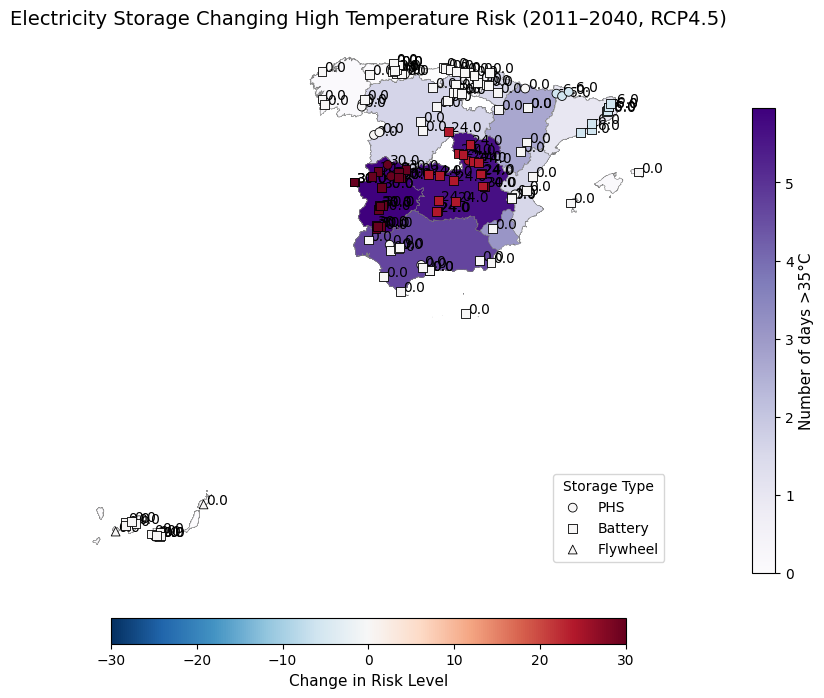

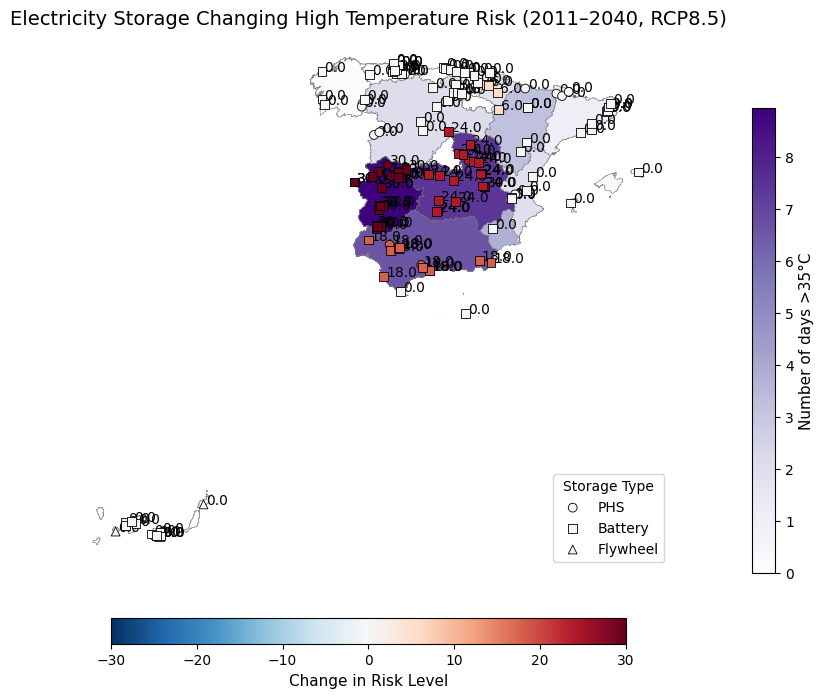

In [29]:
# Function for plotting
def plot_map(temp_col, risk_col, title, temp_change=False):
  fig, ax = plt.subplots(figsize=(10, 8))

  # Merge temperature data with regions for plotting background
  merged_regions_temp = regions.merge(data[['Region', temp_col]], left_on="NAME_1", right_on="Region", how="left")

  # Determine colormap based on whether it's a temperature change map
  cmap_bg = "coolwarm" if not temp_change else "Purples"

  # Background = regional mean temperature
  merged_regions_temp.plot(column=temp_col, cmap=cmap_bg, legend=False, ax=ax, edgecolor='grey', linewidth=0.3)

  # --- BEFORE the overlay, compute shared norm for the risk_col ---
  # use points[risk_col] (ensure it's numeric)
  vals = points[risk_col].to_numpy(dtype=float)
  # decide vmin/vmax. For change maps we want symmetric range around 0:
  if temp_change:
    abs_max = max(abs(vals.min()), abs(vals.max()))
    vmin, vmax = -abs_max, abs_max
    norm_risk = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap_risk = 'RdBu_r'
  else:
    vmin, vmax = vals.min(), vals.max()
    norm_risk = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_risk = 'Reds'

  if temp_change:
      # For risk change, ensure vmin and vmax are symmetric around 0 for the diverging colormap
      abs_max = max(abs(vmin), abs(vmax))
      norm_risk = mcolors.TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)
  else:
      norm_risk = mcolors.Normalize(vmin=vmin, vmax=vmax)


  #Overlay storage facilities
  markers = {'PHS': 'o', 'Battery': 's', 'Flywheel': '^'}
  # plotting order: put larger markers first if you want them behind
  for t, marker in markers.items():
    subset = points[points['Storage type'] == t].copy()
    if subset.empty:
       continue
    xs = subset.geometry.x.values
    ys = subset.geometry.y.values
    cs = subset[risk_col].astype(float).values  # colour values

    sc = ax.scatter(
        xs, ys,
        c=cs,
        cmap=cmap_risk,
        norm=norm_risk,
        marker=marker,
        s=40,               # control marker size here
        edgecolor='black',
        linewidth=0.6,
        label=t,
        zorder=5
    )
# keep reference to the ScalarMappable for the colorbar
  sm_for_colorbar = sc

 # Add text labels to the points
  for i, row in points.iterrows():
      # Check if the risk value is not NaN before adding text
      if pd.notna(row[risk_col]):
          ax.text(row.geometry.x + 0.1, row.geometry.y, f"{row[risk_col]:.1f}", fontsize=10)

  #Add colour bar for temperature (right side)
  sm_temp = cm.ScalarMappable(
        norm=plt.Normalize(
            vmin=merged_regions_temp[temp_col].min(),
            vmax=merged_regions_temp[temp_col].max()
        ),
        cmap=cmap_bg # Use the variable cmap_bg
    )
  cbar_temp = fig.colorbar(sm_temp, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
  cbar_temp.set_label('Number of days >35°C' if temp_change else 'Number of days >35°C', fontsize=11)

  #Add colour bar for risk values (bottom)
  sm_risk = cm.ScalarMappable(norm=norm_risk, cmap=cmap_risk)
  sm_risk.set_array([])   # necessary in some Matplotlib versions
  cbar_risk = fig.colorbar(sm_risk, ax=ax, orientation='horizontal',
                         fraction=0.05, pad=0.08, shrink=0.7)
  cbar_risk.set_label('Change in Risk Level' if temp_change else 'Risk Level', fontsize=11)

  plt.legend(title="Storage Type", loc='lower right')
  plt.title(title, fontsize=14)
  plt.axis('off')
  plt.show()

#Map 4: Future risk with temperature change background RCP4.5
plot_map(
    temp_col='Hot days >35C change RCP4.5',
    risk_col='risk_change4.5',
    title='Electricity Storage Changing High Temperature Risk (2011–2040, RCP4.5)',
    temp_change=True
)

#Map 5: Future risk with temperature change background RCP8.5
plot_map(
    temp_col='Hot days >35C change RCP8.5',
    risk_col='risk_change8.5',
    title='Electricity Storage Changing High Temperature Risk (2011–2040, RCP8.5)',
    temp_change=True
)